In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os
import ali.methods
import ali.ui

In [2]:
# for id in os.listdir('output/my'):
#         if not "P" in id :continue
        
#         hr,step,rhr,info=ali.methods.load(id)
#         if info['covid_test_date']:
#             print(f'{id}')
# #             break
        
# #         alarms = pd.read_csv(f'output/my/{id}/alarm.csv',parse_dates=['datetime'],index_col='datetime').fillna(0)
# #         alarms['datetime'] = pd.to_datetime(alarms['datetime'])
# #         alarms = alarms.set_index('datetime')
# #         if not os.path.isfile(f'output/my/{id}/rhr.h5'):
# #             continue
        
# #         rhr = pd.read_hdf(f'output/my/{id}/rhr.h5', 'rhr',mode='r')
        
# #         display(rhr)

info=pd.read_excel('41591_2021_1593_MOESM3_ESM.xlsx','SourceData_COVID19_Positives',index_col='Participant ID')


{'id': 'P111019', 'device': 'Fitbit', 'covid_test_date': Timestamp('2026-04-19 00:00:00'), 'symptom_date': Timestamp('2026-04-11 00:00:00')}


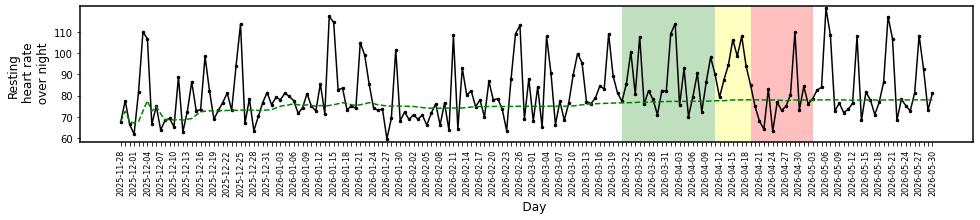

In [3]:
id='P476443'
id=info.index[1]

seg='1T'
import pandas as pd

import ali.methods
import ali.ui
hr,step,rhr,info=ali.methods.load(id)
print(info)
ali.ui.plot(rhr,alerts=pd.DataFrame(),info=info,show=True)
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import json
import os
import compress_pickle
from sklearn.preprocessing import StandardScaler


def selectTrainTestSet(rhr, info,train_days=100,test_days=14):
#     train=rhr.loc[(rhr.index < info['covid_test_date']- pd.to_timedelta(f'{test_days}d'))]
#     test=rhr.loc[(rhr.index >= info['covid_test_date']- pd.to_timedelta(f'{test_days}d'))]
#     return train,test
    if info['covid_test_date']:
        dates_s = rhr.loc[(rhr.index < info['covid_test_date'] - pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique()
        dates_e = list(rhr.loc[(rhr.index > info['covid_test_date'] + pd.to_timedelta(f'{test_days}d'))].index.floor('1D').unique())
    else:
        dates_s = rhr.index.floor('1D').unique()
        dates_e = []
        
    dates_e.append(rhr.index[-1])

    s = min(train_days, len(dates_s)-1)
    e = -min(max(0,train_days-s), len(dates_e))-1
#     print(s)
#     print(dates_s)
#     print(e)
#     print(dates_e)
    train = rhr.loc[(rhr.index < dates_s[s]) | (rhr.index > dates_e[e])]
    test = rhr.loc[(rhr.index >= dates_s[s]) & (rhr.index <= dates_e[e])]

    return train, test


def preprocessing(train, test):
    # display(rhr)

    if os.path.isfile(f'ali/an_data/preprocess.pkl.lz41'):
        scaler = compress_pickle.load(f'ali/an_data/preprocess.pkl.lz4')
    else:
        scaler = StandardScaler()
        scaler = scaler.fit(train[['heartrate']])
        compress_pickle.dump(scaler, f'ali/an_data/preprocess.pkl.lz4')

    train = pd.DataFrame(scaler.transform(train),index=train.index,columns=train.columns)
    test = pd.DataFrame(scaler.transform(test),index=test.index,columns=test.columns)
    return train, test

# def preprocessing(train, test):
#     training_mean = train.mean()
#     training_std = train.std()
#     train = (train - training_mean) / training_std
#     test = (test - training_mean) / training_std
#     return train,test

def create_sequences(data, resolution, seg):
#     data = data.resample(resolution).mean().dropna()
    dates = data.loc[data.index.hour < 7].dropna().resample('1D').count()
    min_acceptable_count = dates.loc[dates['heartrate'] > 0].mean().values[0]/4
    data['date'] = data.index.floor('1D')
    data['time'] = data.index.time
    day_time = data.set_index(['time', 'date']).unstack(level=0).droplevel(0, axis=1).interpolate(limit_direction='both', axis=1)
    out=[]
    for w in dates.rolling(window=f'{seg}D', closed='right'):
        if len(w)==seg :#and w.sum().values[0]>min_acceptable_count*seg:
            res = day_time.reindex(w.index).interpolate(limit_direction='both', axis=0).values
            out.append(np.reshape(res, (res.shape[0]*res.shape[1],1)))
#             out.append(res)
        
    return np.stack(out)

def create_sequences(data,resolution, seg):
    time_steps=int(pd.to_timedelta('7h')/pd.to_timedelta(resolution)*seg)
    data = data.resample(resolution).mean().dropna()
#     data=data.loc[data.index.hour<7]
    values=data.values
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


def createAutoEncoderModel(shape):
    mem=32
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=mem*2, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=mem, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=mem, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=mem*2, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model

def createAutoEncoderModel2(shape):
    mem=32
    model = keras.Sequential(
        [
            layers.Input(shape=(shape[1], shape[2])),
            layers.Conv1D(
                filters=mem*2, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=mem, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=mem, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=mem*2, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

    return model
def createLSTMModel2(shape):
    (timesteps,dim)=shape[1],shape[2]
    model = keras.Sequential()
    model.add(keras.layers.LSTM(50,input_shape=(timesteps,dim),return_sequences=True))

    model.add(keras.layers.Dense(3))
    model.compile(loss='mae', optimizer='adam')
    return model
def createLSTMModel(shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(shape[1], shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
        keras.layers.TimeDistributed(
            keras.layers.Dense(units=shape[2])
        )
    )
    model.compile(loss='mae', optimizer='adam')
    return model


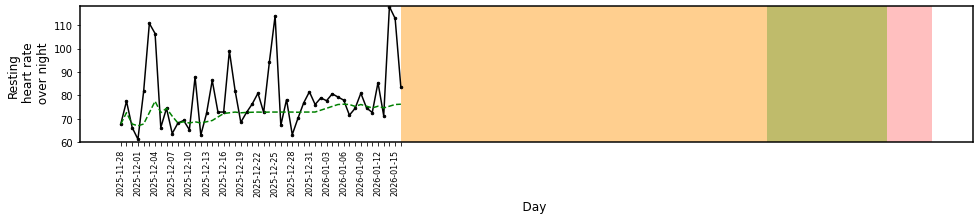

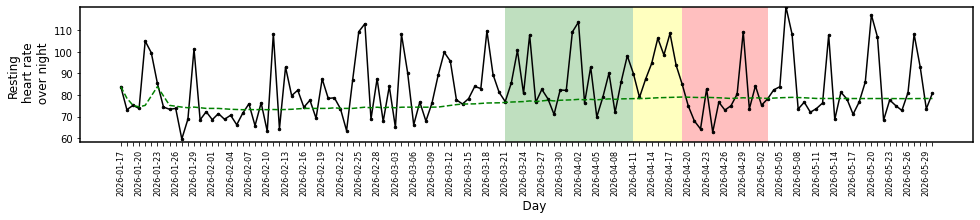

Training input shape:  (15080, 1260, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1260, 50)          10400     
                                                                 
 dense (Dense)               (None, 1260, 3)           153       
                                                                 
Total params: 10,553
Trainable params: 10,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
107/107 [==============================] - 141s 1s/step - loss: 0.3515 - val_loss: 0.2324
Epoch 2/50
107/107 [==============================] - 137s 1s/step - loss: 0.1132 - val_loss: 0.0298
Epoch 3/50
107/107 [==============================] - 139s 1s/step - loss: 0.0240 - val_loss: 0.0224
Epoch 4/50
107/107 [==============================] - 138s 1s/step - loss: 0.0163 - val_loss: 0.0161
Epoc

In [4]:
model='auto-encoder'; resolution='1T'; seg=3
model='lstm';
rhr1=rhr.resample(resolution).mean().dropna()
train, test = selectTrainTestSet(rhr1, info,train_days=50)
ali.ui.plot(train,alerts=pd.DataFrame(),info=info,show=True)
ali.ui.plot(test,alerts=pd.DataFrame(),info=info,show=True)
trainp, testp = preprocessing(train, test)

x_train = create_sequences(trainp, resolution, seg)
print("Training input shape: ", x_train.shape)
if os.path.isfile(f'ali/an_data/model-{model}-{seg}.h51'):
    model = tf.keras.models.load_model(f'ali/an_data/model-{model}-{seg}.h5')
else:
    if model == 'auto-encoder':
        model = createAutoEncoderModel(x_train.shape)
    elif model =='lstm':
        model = createLSTMModel2(x_train.shape)

model.summary()
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

In [5]:
len(train.index.floor('1D').unique())

50

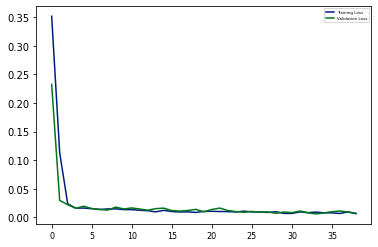

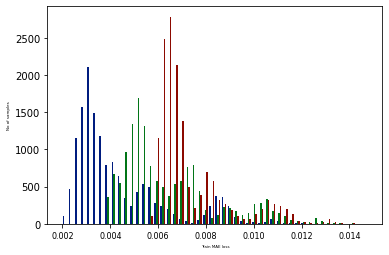

In [6]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

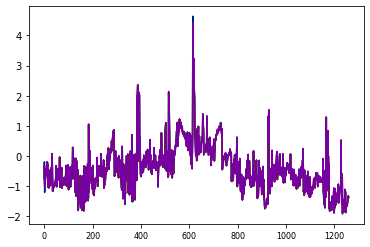

In [7]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

Reconstruction error threshold:  0.014761491720902721


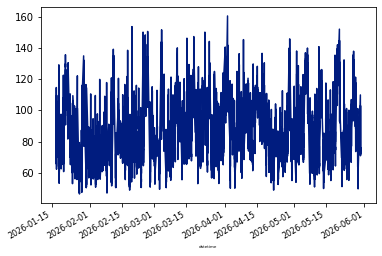

Test input shape:  (43123, 1260, 1)


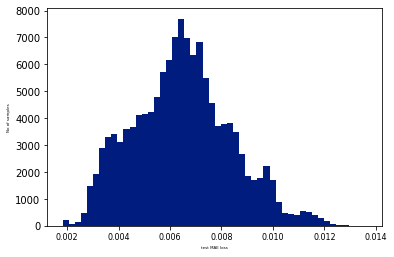

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


In [8]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

fig, ax = plt.subplots()
test.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(testp, seg=seg, resolution=resolution)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


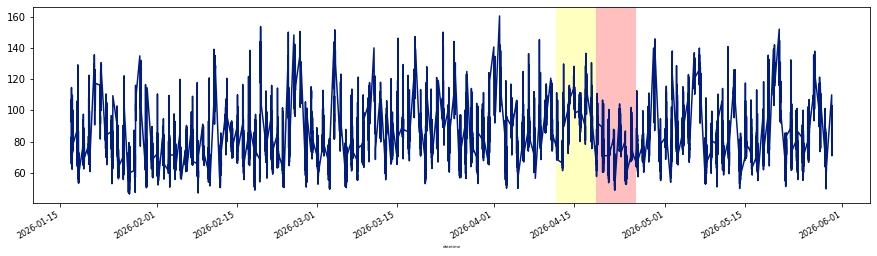

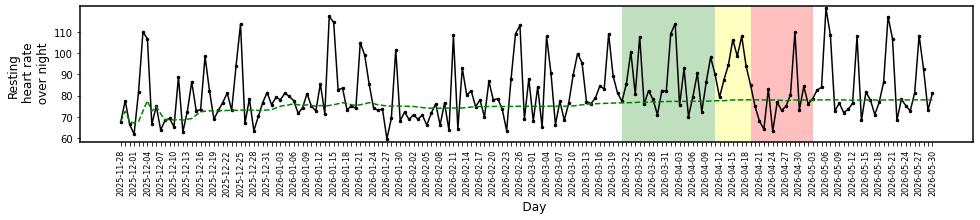

Empty DataFrame
Columns: [heartrate]
Index: []


In [9]:
df_subset = test.iloc[np.where(anomalies)]
fig, ax = plt.subplots()
fig.set_figwidth(15)

test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")

if(info['covid_test_date']!=None):
        plt.axvspan(info['covid_test_date'], min(test.index[-1], info['covid_test_date']+pd.to_timedelta('7d')), facecolor='red', alpha=0.25, label='Covid')
        plt.axvspan(info['covid_test_date'], max(test.index[1], info['covid_test_date']-pd.to_timedelta('7d')), facecolor='yellow', alpha=0.25, label='Covid')
plt.show()



dates = test.iloc[np.where(anomalies)].resample('1D').count().fillna(0).rename(columns={'heartrate': 'count'})

dates['alarm'] = (dates['count'] > 0)*2
# return dates
ali.ui.plot(rhr,alerts=dates,info=info,show=True)
print(test.iloc[np.where(anomalies)])